In [1]:
#%% Imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Import "local" packages
import hyspec_io, hyspec_ml, image_render, preprocess 

2024-02-21 09:00:57.758495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#%% Paths
tmp_save_dir = Path('/media/mha114/Massimal2/Massimal/X_TemporaryDeletableFiles/PrelimSkalmenDeglint')
im_paths = ['/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_31-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_32-Crop Wavelengths.bip.hdr', # første eksempel
            '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_79-Crop Wavelengths.bip.hdr', # dyp sand midt i bildet
            '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_81-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_24-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_30-Crop Wavelengths.bip.hdr', # godt eksempel
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_42-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_20-Crop Wavelengths.bip.hdr', # godt eksempel
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_25-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_32-Crop Wavelengths.bip.hdr'] # godt eksempel
im_paths = [Path(p) for p in im_paths]


In [3]:
for im_path in im_paths[-1:]:
    (im,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(im_path)

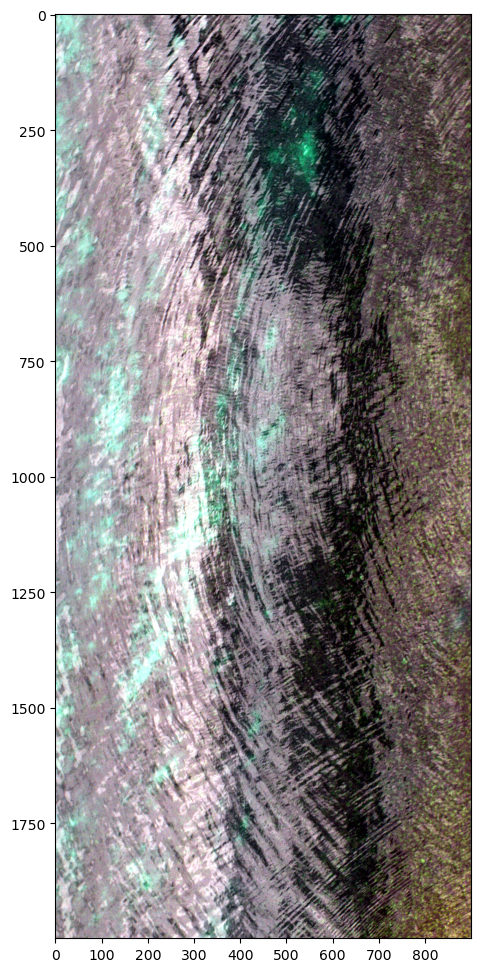

In [4]:
#%% Show RGB
fig,ax = plt.subplots(ncols=1,figsize=(10,12))
ax.imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
#ax[1].imshow(image_render.percentile_stretch(im_nir,separate_bands = False),cmap='gray')
plt.show()

In [5]:
# Vectorize image
im_vectorizer = hyspec_ml.ImageVectorizer(nRows=im.shape[0],nCols=im.shape[1])
im_2d = im_vectorizer.image3d_to_matrix(im)
print(f'Shape of original image: {im.shape}')
print(f'Shape of vectorized image: {im_2d.shape}')

Shape of original image: (2000, 900, 255)
Shape of vectorized image: (1800000, 255)


In [6]:
# PCA transform 
pca = PCA(n_components=6)
im_2d_pca = pca.fit_transform(im_2d)

In [7]:
im_pca = im_vectorizer.matrix_to_image3d(im_2d_pca)
print(f'Shape of PCA image: {im_pca.shape}')

Shape of PCA image: (2000, 900, 6)


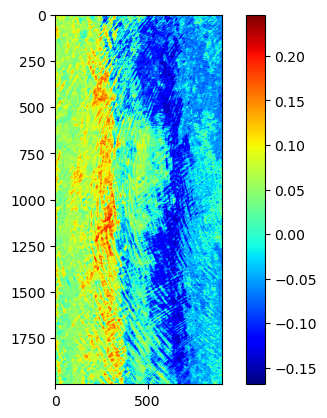

In [8]:
plt.imshow(im_pca[:,:,0],cmap='jet')
plt.colorbar()

In [9]:
X_mean = pca.mean_
W_pca = pca.components_
print(W_pca.shape)

(6, 255)


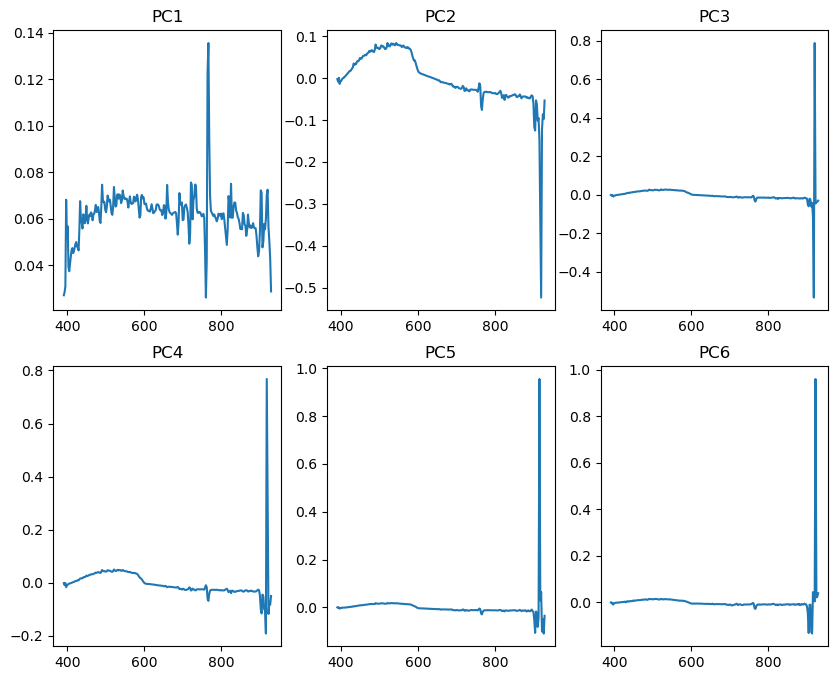

In [10]:
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(10,8))
for i,ax in enumerate(axes.reshape(-1)):
    ax.plot(wl,W_pca[i])
    ax.set_title(f'PC{i+1}')
plt.show()

# Note on principal component shape
When the PCA model is fitted to data that has not been standardized / normalized, the "last" components (from PC3 onwards) are dominated by noise in the NIR band. The noise contributes significantly to the variance, and therefore has an "outsized" impact on the principal components.

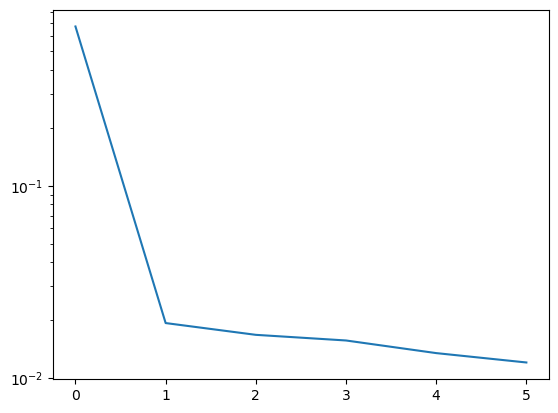

In [24]:
# Show explained varance
plt.semilogy(pca.explained_variance_ratio_)
plt.show()

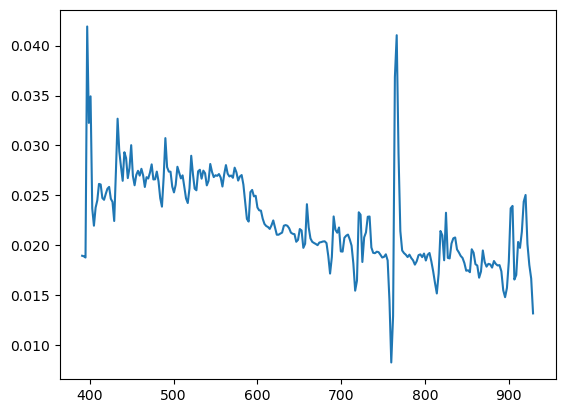

In [21]:
# Show mean vector
plt.plot(wl,X_mean)
plt.show()

In [13]:
pc1 = W_pca[0]
pc1 = pc1.reshape((1,1,-1))
print(pc1.shape)

(1, 1, 255)


In [14]:
im_pc1 = im_pca[:,:,0:1]
# im_pc1[im_pc1<0] = 0
# im_glint = im_pca[:,:,0:1]*pc1 
im_glint = im_pc1*pc1 
print(im_glint.shape)

(2000, 900, 255)


In [15]:
im_noglint = im - im_glint

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


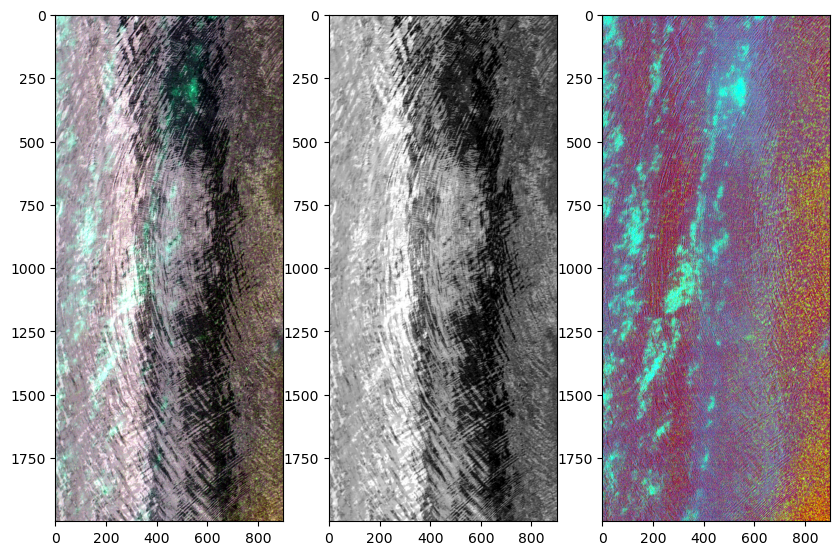

In [16]:
fig,ax = plt.subplots(ncols=3,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(im_glint[:,:,rgb_ind]))
ax[2].imshow(image_render.percentile_stretch(im_noglint[:,:,rgb_ind]))
plt.show()

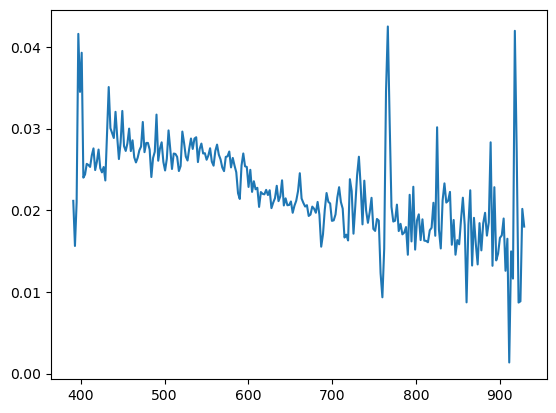

In [17]:
plt.plot(wl,im_noglint[1000,600,:]) 

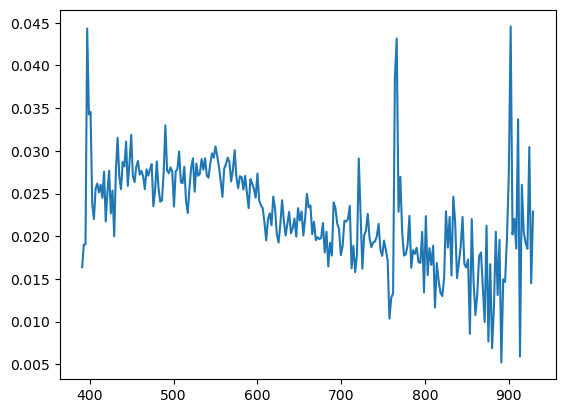

In [18]:
plt.plot(wl,im_noglint[850,150,:])

In [19]:
im_path

PosixPath('/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_32-Crop Wavelengths.bip.hdr')

In [20]:
# save_file_path = tmp_save_dir / im_path.name
# hyspec_io.save_envi_image(str(save_file_path),im_noglint,metadata)